Note: you may need to restart the kernel to use updated packages.
Loaded 53657 rows and 15 columns
Loaded 53657 rows and 15 columns
Graph nodes: 61004, edges: 53641
Computing approximate betweenness centrality with k=100
Graph nodes: 61004, edges: 53641
Computing approximate betweenness centrality with k=100
Computing PageRank with a time limit of 10s (adjust max_time_seconds if needed)
Computing PageRank with a time limit of 10s (adjust max_time_seconds if needed)
PageRank time limit reached after 1 iterations; returning partial scores
PageRank time limit reached after 1 iterations; returning partial scores


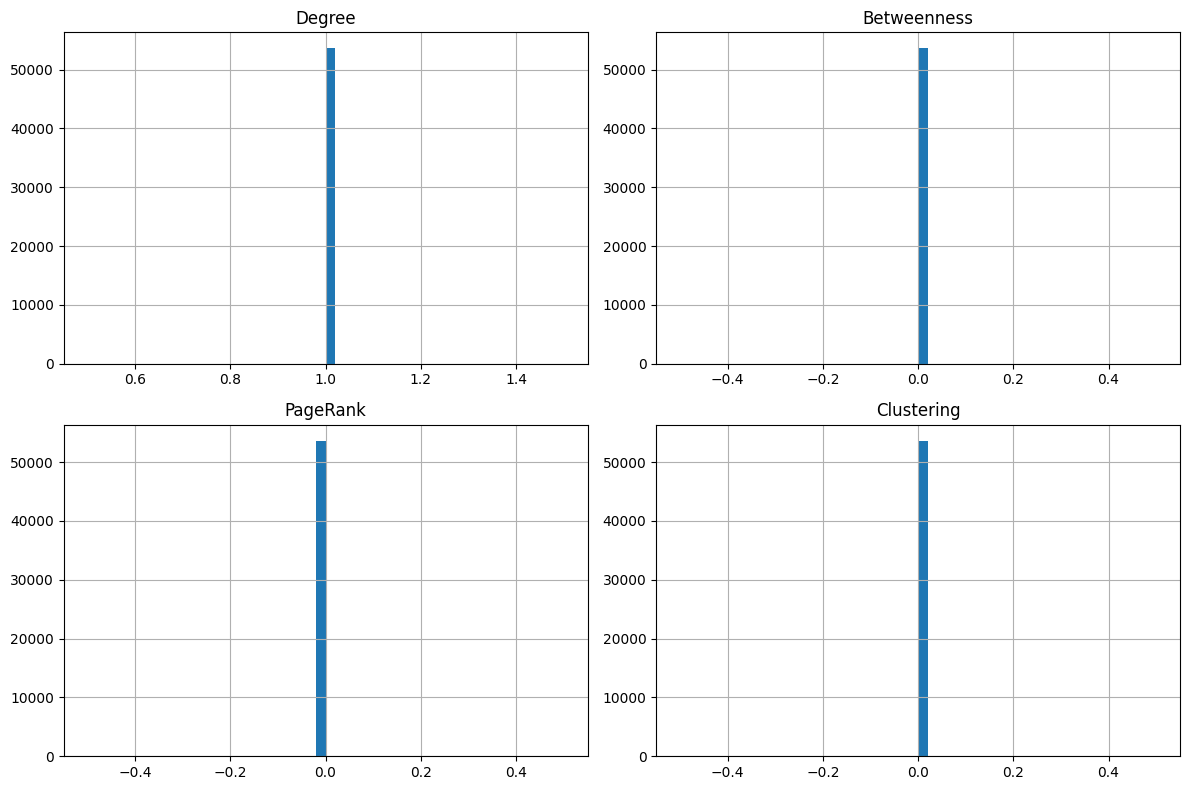

Saved graph-enhanced features to ../data/processed/phishing_graph_features.csv


In [1]:
# 03-graph-visuals.ipynb
# Graph-Based Feature Engineering with NetworkX

"""
## 03 - Graph Feature Engineering

This notebook:
1. Loads `phishing_features.csv` (phishing URLs & basic features).
2. Builds bipartite graph: sender → URL → domain.
3. Computes graph metrics for URL & domain nodes (degree, betweenness, clustering, PageRank).
4. Visualizes small subgraphs or distributions of metric values.
5. Merges graph metrics into feature table and saves `phishing_graph_features.csv`.
"""

# Ensure required package is available in the notebook environment
%pip install --quiet networkx

#%%
# 1. Imports and Config
import os
import time
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Paths
FEATURES_CSV = os.path.join('..', 'data', 'processed', 'phishing_features.csv')
OUTPUT_GRAPH = os.path.join('..', 'data', 'processed', 'phishing_graph_features.csv')

#%%
# 2. Load features
df = pd.read_csv(FEATURES_CSV)
print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns")

#%%
# 3. Build bipartite graph
G = nx.DiGraph()
for idx, row in df.iterrows():
    url = row['url']
    domain = row.get('domain', None)
    sender = row.get('sender_domain', None)
    # Add nodes
    G.add_node(url, type='url')
    if pd.notna(domain):
        G.add_node(domain, type='domain')
        G.add_edge(url, domain)
    if sender and pd.notna(sender):
        G.add_node(sender, type='sender')
        G.add_edge(sender, url)

print(f"Graph nodes: {len(G.nodes())}, edges: {len(G.edges())}")

#%%
# 4. Compute graph metrics
# Degree centrality (node degree)
degree_dict = dict(G.degree())

# Adaptive betweenness: choose k=min(100, int(sqrt(N))) to balance speed/accuracy
N = len(G.nodes())
import math
k_default = min(100, max(10, int(math.sqrt(N))))
print(f"Computing approximate betweenness centrality with k={k_default}")
between_dict = nx.betweenness_centrality(G, k=k_default, seed=42)

# PageRank: sparse power-iteration fallback with time limit

def pagerank_sparse(G, alpha=0.85, max_iter=100, tol=1.0e-6, max_time_seconds=10):
    start = time.time()
    nodes = list(G.nodes())
    N = len(nodes)
    idx = {n:i for i,n in enumerate(nodes)}
    out_links = [[] for _ in range(N)]
    out_deg = [0]*N
    for u in G.nodes():
        u_idx = idx[u]
        outs = [v for v in G.successors(u)]
        out_deg[u_idx] = len(outs)
        for v in outs:
            out_links[u_idx].append(idx[v])
    pr = [1.0/N]*N
    base = (1.0 - alpha)/N
    for iteration in range(max_iter):
        if time.time() - start > max_time_seconds:
            print(f"PageRank time limit reached after {iteration} iterations; returning partial scores")
            break
        new_pr = [base]*N
        for u_idx in range(N):
            if out_deg[u_idx] == 0:
                contrib = pr[u_idx]/N
                for i in range(N):
                    new_pr[i] += alpha * contrib
            else:
                contrib = pr[u_idx]/out_deg[u_idx]
                for v_idx in out_links[u_idx]:
                    new_pr[v_idx] += alpha * contrib
        err = sum(abs(new_pr[i]-pr[i]) for i in range(N))
        pr = new_pr
        if err < tol:
            print(f"PageRank converged after {iteration+1} iterations")
            break
    return {nodes[i]: pr[i] for i in range(N)}

print('Computing PageRank with a time limit of 10s (adjust max_time_seconds if needed)')
try:
    pagerank_dict = nx.pagerank_numpy(G)
except Exception:
    pagerank_dict = pagerank_sparse(G, max_time_seconds=10)

# Clustering (undirected)
clust = nx.clustering(G.to_undirected())

#%%
# 5. Assign metrics back to DataFrame
# Initialize columns
df['graph_degree'] = df['url'].map(degree_dict)
# Betweenness
df['graph_betweenness'] = df['url'].map(between_dict)
# PageRank
df['graph_pagerank'] = df['url'].map(pagerank_dict)
# Clustering
df['graph_clustering'] = df['url'].map(clust)

#%%
# 6. Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
df['graph_degree'].hist(bins=50, ax=axes[0,0]); axes[0,0].set_title('Degree')
df['graph_betweenness'].hist(bins=50, ax=axes[0,1]); axes[0,1].set_title('Betweenness')
df['graph_pagerank'].hist(bins=50, ax=axes[1,0]); axes[1,0].set_title('PageRank')
df['graph_clustering'].hist(bins=50, ax=axes[1,1]); axes[1,1].set_title('Clustering')
plt.tight_layout()
plt.show()

#%%
# 7. Save enriched features
# Export only new graph features or full table
df.to_csv(OUTPUT_GRAPH, index=False)
print(f"Saved graph-enhanced features to {OUTPUT_GRAPH}")
